# Example - Harris, Green and Davies - 1991 EE

In this notebook we show that our thermal model implementations are consistent to those published
in the literature. We take the data and best-fit parameters published in Harris, Davies and Green 1998 for asteroid 1991 EE. Using the published best-fit parameters, and the published data, we recreate Figure 3 from the paper. 

This recreated figure serves as Figure 6 in the ATM paper.

See paper for more details: http://adsabs.harvard.edu/abs/1998Icar..135..441H

In [1]:
import os 
import sys
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("../..")

import atm

%matplotlib inline

In [2]:
DPI = 600
SAVE_DIR = "../plots/"
FORMAT = "png"

SAVE_FIGS = True

## Data Injest

In [3]:
# Previously daved the data
data = pd.read_csv("../../data/1991EE_harris_davies_green.txt", sep=" ")

In [4]:
data

,wavelength_microns,num_obs,r_au,delta_au,alpha_deg,v_mag,flux_lambda,fluxErr_lambda,flux_nu,fluxErr_nu,STM_eta,NEATM_eta,STM_D_km,FRM_D_km,NEATM_D_km,STM_pv,FRM_pv,NEATM_pv
0,1.25,3,1.063,0.07,35.4,11.54,7.450000e-14,1.200000e-15,0.0388,0.6,0.756,1.15,0.85,1.4,1.01,0.42,0.16,0.3
1,1.65,2,1.063,0.07,35.4,11.09,4.100000e-14,8.000000e-16,0.0372,0.7,0.756,1.15,0.85,1.4,1.01,0.42,0.16,0.3
2,2.20,2,1.063,0.07,35.4,11.06,1.530000e-14,3.000000e-16,0.0247,0.5,0.756,1.15,0.85,1.4,1.01,0.42,0.16,0.3
3,3.73,2,1.063,0.07,35.4,9.17,1.110000e-14,4.000000e-16,0.0513,1.7,0.756,1.15,0.85,1.4,1.01,0.42,0.16,0.3
4,4.64,2,1.063,0.07,35.4,7.31,2.860000e-14,1.300000e-15,0.2050,9.0,0.756,1.15,0.85,1.4,1.01,0.42,0.16,0.3
5,4.76,6,1.063,0.07,35.4,7.10,3.250000e-14,1.500000e-15,0.2460,12.0,0.756,1.15,0.85,1.4,1.01,0.42,0.16,0.3
6,8.70,1,1.063,0.07,35.4,3.47,8.630000e-14,8.300000e-15,2.1800,210.0,0.756,1.15,0.85,1.4,1.01,0.42,0.16,0.3
7,9.60,1,1.063,0.07,35.4,3.09,7.700000e-14,7.400000e-15,2.3700,230.0,0.756,1.15,0.85,1.4,1.01,0.42,0.16,0.3
8,10.00,13,1.063,0.07,35.4,2.86,8.790000e-14,1.400000e-15,2.9300,47.0,0.756,1.15,0.85,1.4,1.01,0.42,0.16,0.3
9,10.30,1,1.063,0.07,35.4,3.02,6.600000e-14,6.400000e-15,2.3400,220.0,0.756,1.15,0.85,1.4,1.01,0.42,0.16,0.3


## Plot Data

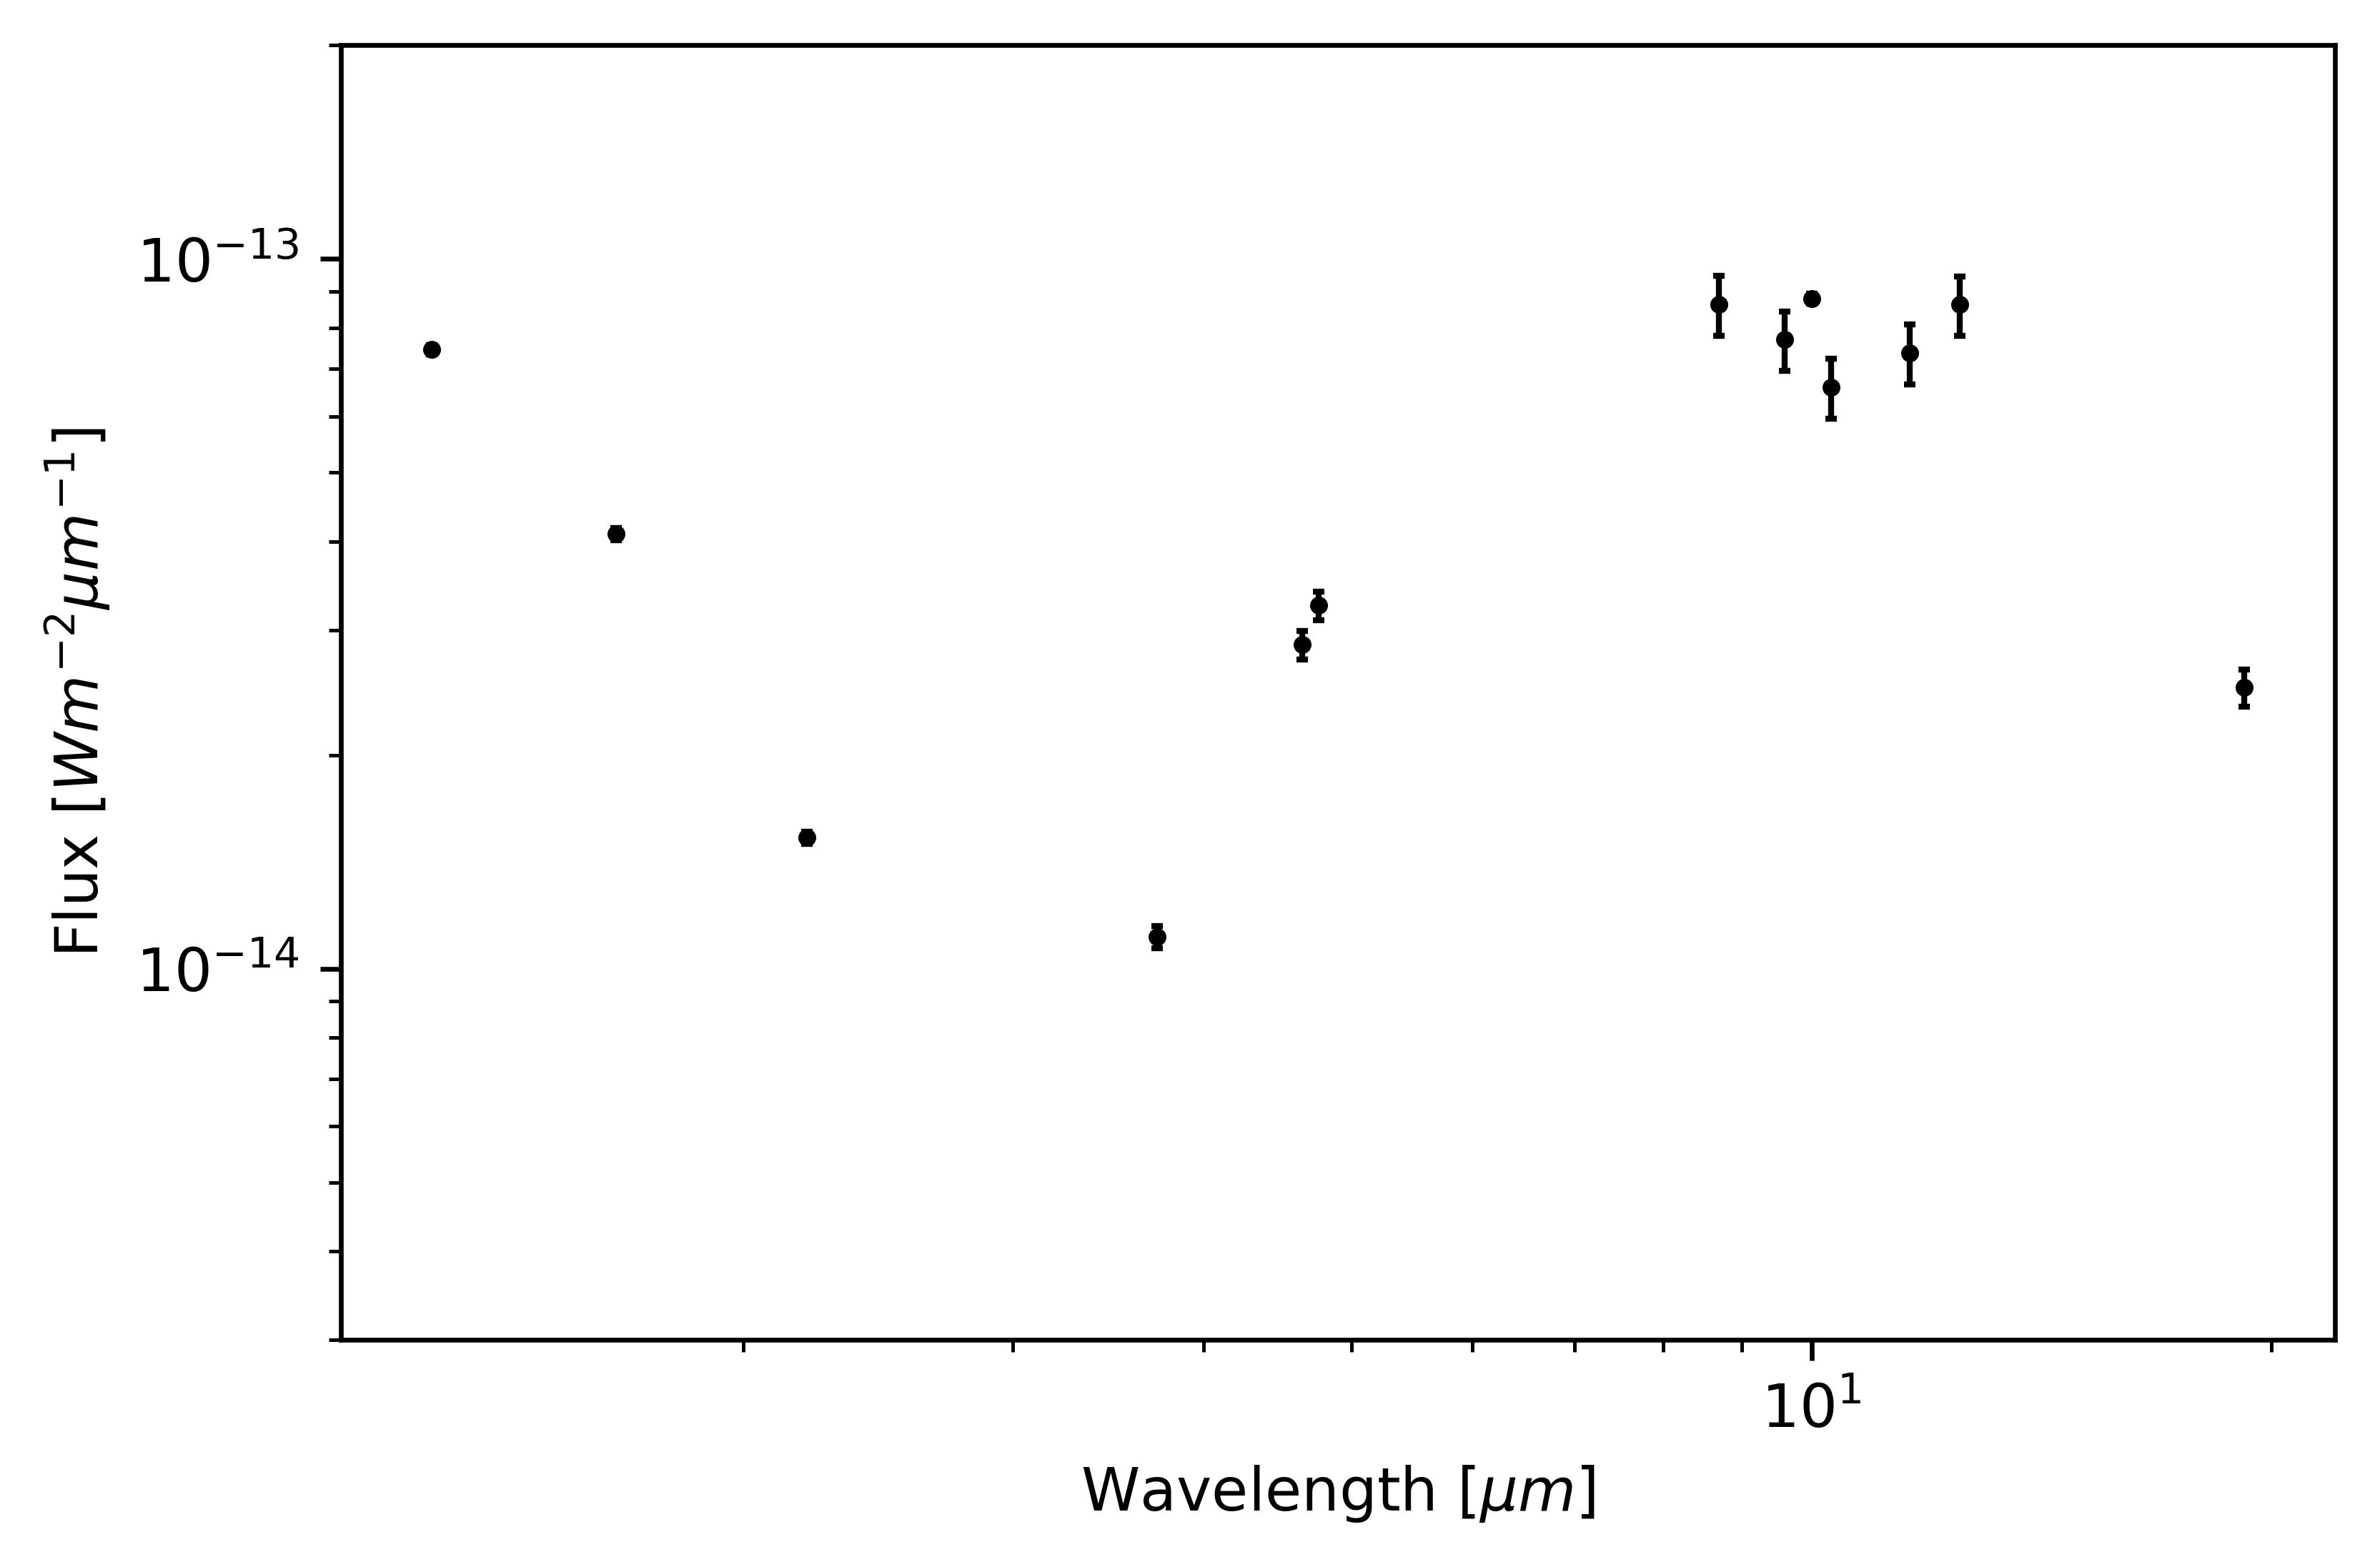

In [5]:
fig, ax = plt.subplots(1, 1, dpi=DPI)
ax.errorbar(data["wavelength_microns"].values,
            data["flux_lambda"].values, 
            yerr=data["fluxErr_lambda"].values,
            fmt='o',
            c="k",
            ms=2,
            capsize=1,
            elinewidth=1,
            label="1991 EE - Harris, Green, and Davies")

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylabel(r"Flux [$W m^{-2} \mu m^{-1}$]")
ax.set_xlabel(r"Wavelength [$\mu m$]")
ax.set_ylim(3e-15, 2e-13);

## Model Fluxes

In [6]:
from atm.models import STM, FRM, NEATM
from atm.functions import calcFluxLambdaAtObs, calcFluxLambdaAtObsWithSunlight
from atm.functions import calcTss
from atm.functions import calcQ

#### Extract observing geometry and assumed values

In [7]:
m_to_mum = 1e6 # simple conversion from m to micron
km_to_m = 1e3 # conversion km to m

lambd = np.linspace(1e-6, 30e-6, 300)

# Observing geometry is constant
r = np.ones(len(lambd)) * data["r_au"].values[0]
delta = np.ones(len(lambd)) * data["delta_au"].values[0]
alpha = np.ones(len(lambd)) * np.radians(data["alpha_deg"].values[0]) # convert to radians
eps = np.ones(len(lambd)) * 0.9 # assumed in paper
G = np.ones(len(lambd)) * 0.23 # assumed in paper

#### Standard Thermal Model (STM)

In [8]:
p_v_STM = np.ones(len(lambd)) * data["STM_pv"].values[0]
D_STM = np.ones(len(lambd)) * data["STM_D_km"].values[0] * km_to_m # convert to m
eta_STM = np.ones(len(lambd)) * data["STM_eta"].values[0]
model = STM(verbose=False)

stm_flux_ws = calcFluxLambdaAtObsWithSunlight(model, r, delta, lambd, calcTss(r, p_v_STM, eps, G, eta_STM), D_STM, alpha, eps, p_v_STM, G)

#### Fast-Rotating Model (FRM)

In [9]:
p_v_FRM = np.ones(len(lambd)) * data["FRM_pv"].values[0]
D_FRM = np.ones(len(lambd)) * data["FRM_D_km"].values[0] * km_to_m # convert to m
eta_FRM = np.ones(len(lambd)) * np.pi # canonical value
model = FRM(verbose=False)

frm_flux_ws = calcFluxLambdaAtObsWithSunlight(model, r, delta, lambd, calcTss(r, p_v_FRM, eps, G, eta_FRM), D_FRM, alpha, eps,  p_v_FRM,  G)

#### Near-Earth Asteroid Thermal Model (NEATM)

In [10]:
p_v_NEATM = np.ones(len(lambd)) * data["NEATM_pv"].values[0]
D_NEATM = np.ones(len(lambd)) * data["NEATM_D_km"].values[0] * km_to_m # convert to m
eta_NEATM = np.ones(len(lambd)) * data["NEATM_eta"].values[0]
model = NEATM(verbose=False)

neatm_flux_ws = calcFluxLambdaAtObsWithSunlight(model, r, delta, lambd, calcTss(r, p_v_NEATM, eps, G, eta_NEATM), D_NEATM, alpha, eps, p_v_NEATM, G)

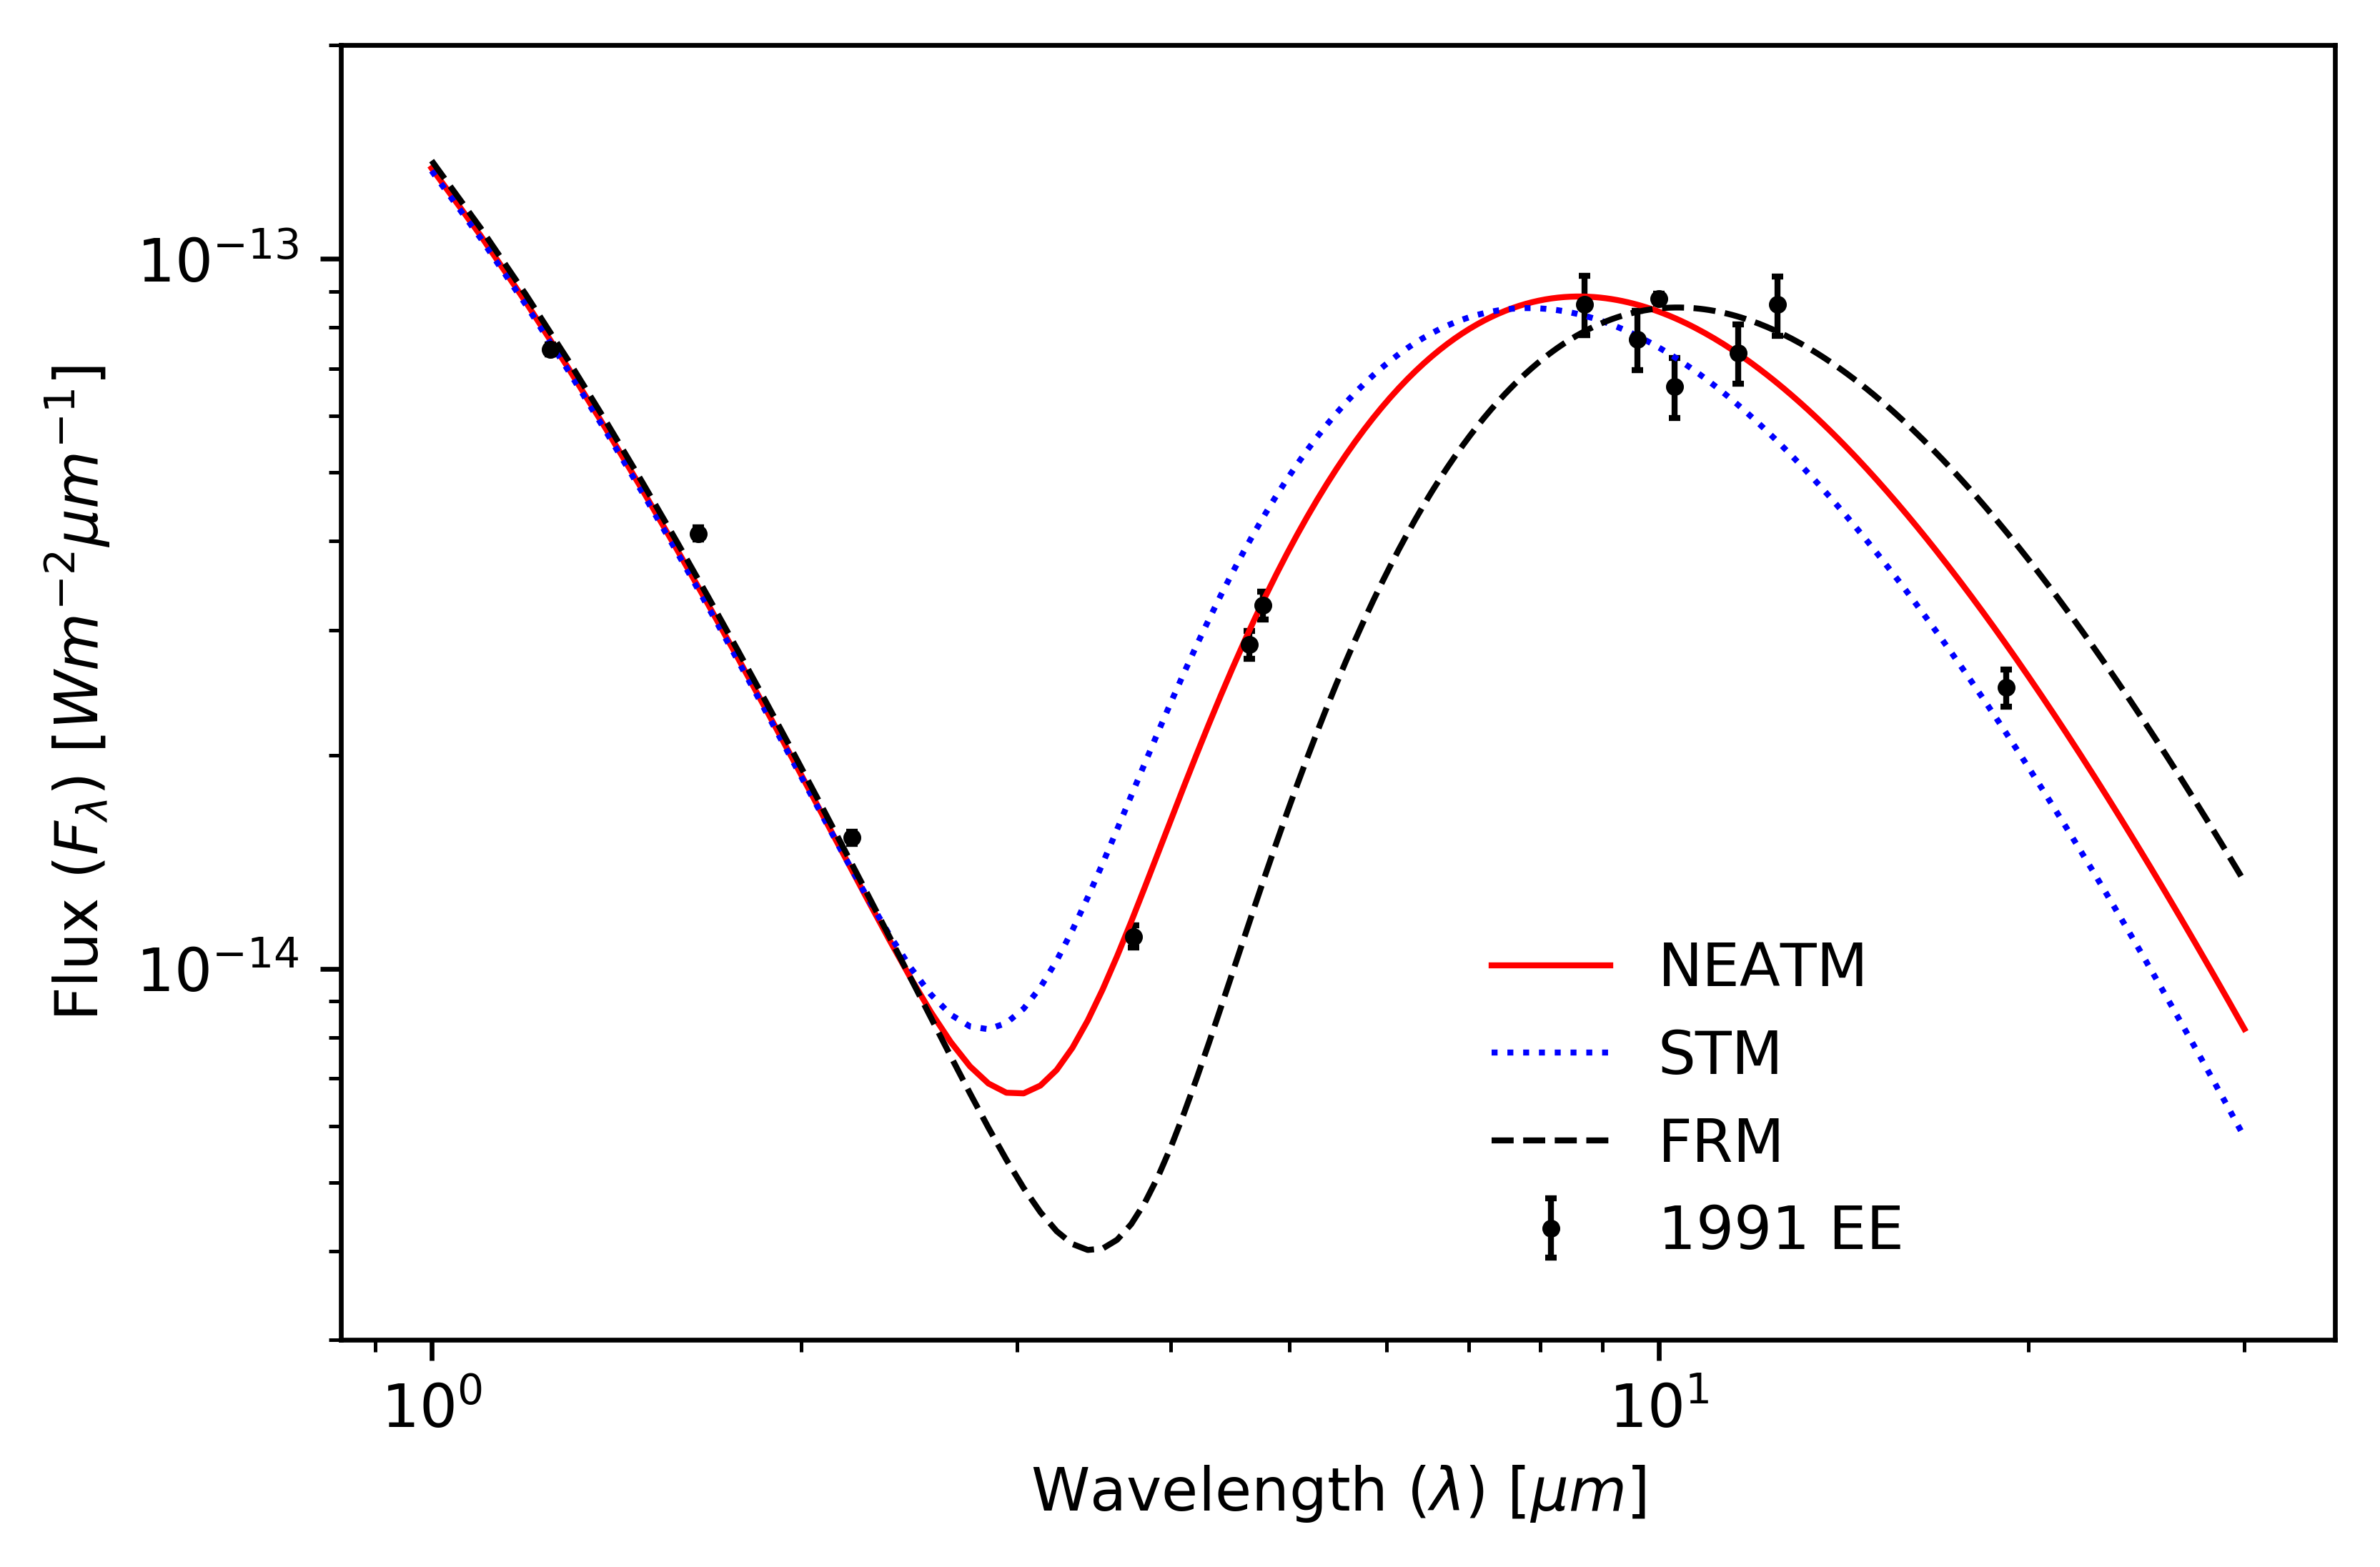

In [11]:
fig, ax = plt.subplots(1, 1, dpi=DPI)
ax.errorbar(data["wavelength_microns"].values,
            data["flux_lambda"].values, 
            yerr=data["fluxErr_lambda"].values,
            fmt='o',
            c="k",
            ms=2,
            capsize=1,
            elinewidth=1,
            label="1991 EE")

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylabel(r"Flux ($F_\lambda$) [$W m^{-2} \mu m^{-1}$]")
ax.set_xlabel(r"Wavelength ($\lambda$) [$\mu m$]")

ax.plot(m_to_mum * lambd, 1/m_to_mum * neatm_flux_ws, lw=1, label="NEATM", c="r")
ax.plot(m_to_mum * lambd, 1/m_to_mum * stm_flux_ws, lw=1, label="STM", ls=":", c="b")
ax.plot(m_to_mum * lambd, 1/m_to_mum * frm_flux_ws, lw=1, label="FRM", ls="--", c="k")

ax.legend(bbox_to_anchor=(0.55,0.35), frameon=False)
ax.set_ylim(3e-15, 2e-13);
if SAVE_FIGS is True:
    fig.savefig(os.path.join(SAVE_DIR, "validation_1991EE".format(FORMAT)), bbox_inches='tight')